In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def func_state_transition(self, nu, omega, time, pose): #追加（IdealRobotからコピー）
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*math.sqrt(nu/time) + ns[1]*math.sqrt(omega/time)
        pomega = omega + ns[2]*math.sqrt(nu/time) + ns[3]*math.sqrt(omega/time)
        self.pose = self.func_state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_vars): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_vars
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04}):
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
    def decision(self, observation=None):        ###MclAgent5
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.mcl.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in a.mcl.particles:
    print(p.pose)

[ 0.01999481  0.00018252  0.01825605]
[  2.66958539e-02   3.44603941e-05   2.58170239e-03]
[ 0.01987944  0.00019339  0.01945524]
[ 0.02003769  0.00018416  0.01838112]
[ 0.0236927   0.00018116  0.01529258]
[ 0.02502749  0.00019878  0.01588474]
[ 0.02065435  0.00014464  0.0140053 ]
[  1.70041078e-02   9.81128870e-05   1.15397761e-02]
[ 0.02555521  0.0002412   0.01887604]
[ 0.01996463  0.00019627  0.0196616 ]
[ 0.01703571  0.00013153  0.01544186]
[ 0.02077327  0.00013705  0.01319488]
[  1.78536510e-02   7.89446751e-05   8.84347528e-03]
[ 0.013433    0.00012866  0.01915506]
[ 0.02141757  0.00029211  0.02727608]
[ 0.01655407  0.00014554  0.01758323]
[  1.92410344e-02  -2.20515406e-05  -2.29213570e-03]
[ 0.01819257  0.00018568  0.02041232]
[ 0.01751019  0.00021902  0.02501506]
[ 0.01953407  0.00018596  0.01903933]
[ 0.02413878  0.00011863  0.00982901]
[ 0.01958718  0.00018883  0.01928039]
[ 0.01633499  0.00017242  0.02111031]
[  1.89734305e-02   8.19221854e-05   8.63541007e-03]
[ 0.01947004 

<IPython.core.display.Javascript object>


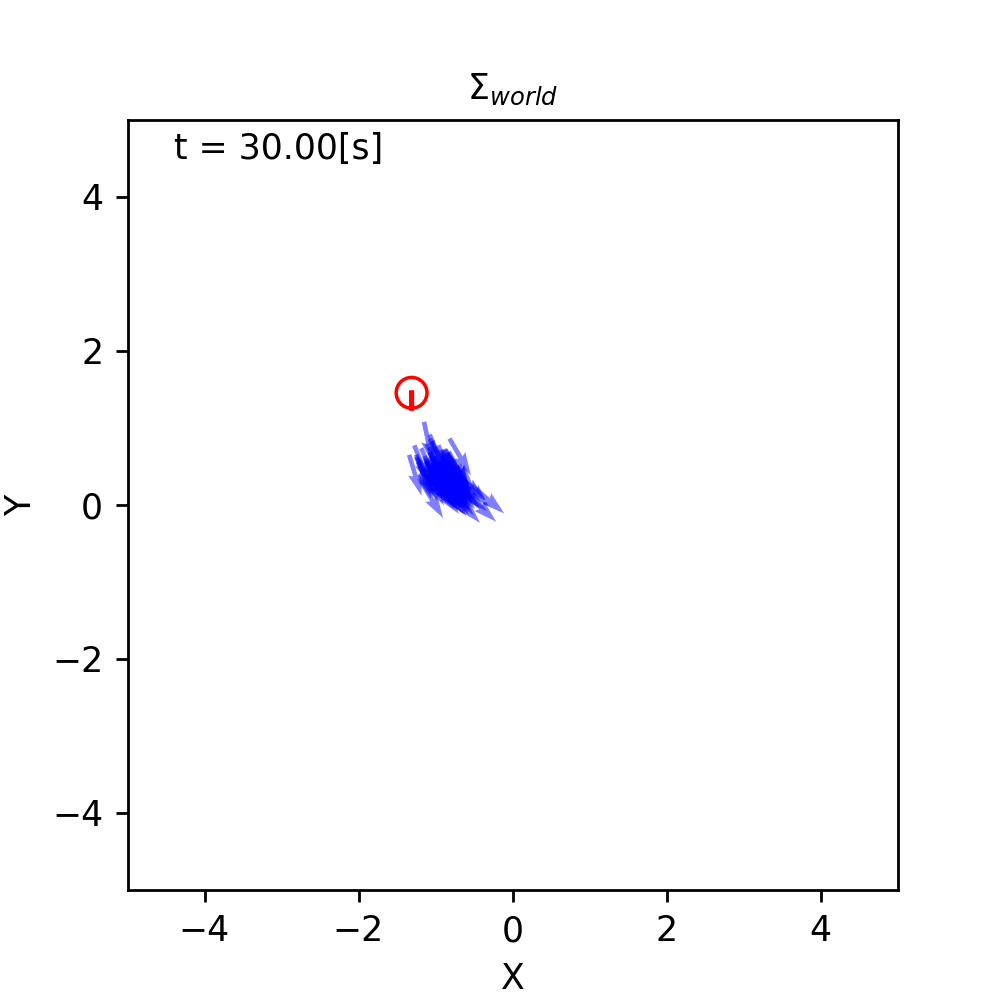

In [6]:
time_interval = 0.1  ###draw_mcl5###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()